In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.deep7_model import *
import hierarchical_yolo.utils

In [3]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Other or Can't Tell
  5: Ehu
  6: Lehi
  7: Onaga
  8: Snapper
  9: Grouper
  10: Object
'''

deep7_hierarchy = {
    0: 8,
    1: 8,
    2: 9,
    3: 8,
    5: 8,
    6: 8,
    7: 8,
    4: 10,
    8: 10,
    9: 10
}

In [4]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Fish
  5: Ehu
  6: Lehi
  7: Onaga
'''

deep7_hierarchy = {
    0: 4,
    1: 4,
    2: 4,
    3: 4,
    5: 4,
    6: 4,
    7: 4
}

In [5]:
from ultralytics import settings

# View all settings
print(settings)

JSONDict("/home/noaa_brown/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/noaa_brown/datasets",
  "weights_dir": "/home/noaa_brown/hierarchical_yolo/weights",
  "runs_dir": "/home/noaa_brown/hierarchical_yolo/runs",
  "uuid": "2768c477e7938b5779aff75aed83103f60cf5680dbe7372dfa0b27c233b7d105",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true
}


In [6]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [7]:
DATA = '../data'
UPLOAD_URL = 'https://storage.googleapis.com/nmfs_odp_hq/nodd_tools/datasets/oceaneyes/annotation_number_balanced_sample/annotations.json'
DOWNLOAD_PATH = os.path.join(DATA, 'download')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'annotations.json')
YOLO_PATH = os.path.join(DOWNLOAD_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'annotations', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [8]:
uploaded_coco_file = requests.get(UPLOAD_URL)
with open(COCO_PATH, 'wb') as f:
    f.write(uploaded_coco_file.content)
    coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [9]:
def coco_category_dist(coco):
    import matplotlib.pyplot as plt
    cats, cnt = np.unique(list(map(lambda x: x['category_id'], coco.anns.values())), return_counts=True)
    cat_names = list(map(lambda cat_id: coco.cats[cat_id]['name'], cats))
    plt.bar(cat_names, cnt)
    for i, value in enumerate(cnt):
        plt.text(i, value + 0.5, str(value), ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

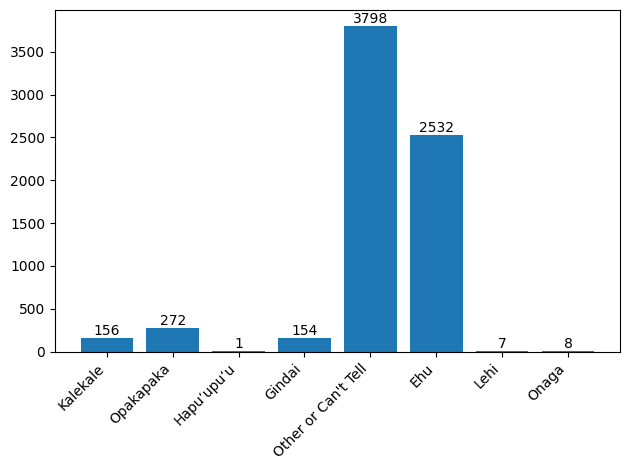

In [10]:
coco_category_dist(coco)

In [11]:
coco.info()

year: 2024
version: 0.1
description: https://www.zooniverse.org/projects/benjamin-dot-richards/oceaneyes/about/research
contributor: None
url: None
date_created: 2025-02-06T20:56:54.886937+00:00


In [12]:
pycocowriter.coco2yolo.coco2yolo(DOWNLOAD_PATH, YOLO_PATH)

Annotations /home/noaa_brown/hierarchical_yolo/data/download/annotations.json: 100%|██████████| 200/200 [00:00<00:00, 911.15it/s] 

COCO data converted successfully.
Results saved to /home/noaa_brown/hierarchical_yolo/notebooks/coco_converted
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
downloaded 0/200 images (t=0.0s)
downloaded 1/200 images (t=0.0s)
downloaded 2/200 images (t=0.0s)
downloaded 3/200 images (t=0.0s)
downloaded 4/200 images (t=0.0s)
downloaded 5/200 images (t=0.0s)
downloaded 6/200 images (t=0.0s)
downloaded 7/200 images (t=0.0s)
downloaded 8/200 images (t=0.0s)
downloaded 9/200 images (t=0.0s)
downloaded 10/200 images (t=0.0s)
downloaded 11/200 images (t=0.0s)
downloaded 12/200 images (t=0.0s)
downloaded 13/200 images (t=0.0s)
downloaded 14/200 images (t=0.0s)
downloaded 15/200 images (t=0.0s)
downloaded 16/200 images (t=0.0s)
downloaded 17/200 images (t=0.0s)
downloaded 18/200 images (t=0.0s)
downloaded 19/200 images (t=0.0s)
downloaded 20/200 images (t=0.0s)
downloaded 21/200 i

In [13]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [14]:
mlflow.autolog()

In [15]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [ ]:
if RETRAIN:
    results = model.train(
        data=YOLO_TRAIN_YAML, 
        epochs=5, imgsz=640, 
        device=devices, 
        batch=max(len(devices), 1),
        trainer=Deep7HierarchicalDetectionTrainer
    )

In [16]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/download/yolo_training_data/annotations/images/20190925_202536_20190925.204007.283.009978.jpg'

In [17]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [18]:
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt')).to('cuda')
trained_model.eval()

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [19]:
trained_model.overrides.get('imgsz', None)

In [20]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)
prediction = next(predictions)
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([5., 5., 5., 5., 5., 5., 4., 4., 5., 4., 5., 5., 4., 5., 5., 5., 4., 5., 4., 5., 4., 5., 5., 5., 4., 4., 4., 5., 5., 4., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 5., 5., 5., 4., 5., 4., 4., 4., 4., 5., 5., 5., 5., 4., 4., 4., 4., 5., 4., 4., 5., 4., 4., 5., 4., 5., 4., 4., 4., 4., 5., 4., 4., 4., 4., 4., 5., 4.,
        4., 4., 5., 5., 4., 5., 5., 5., 4., 4., 5., 4., 4., 5., 4., 5., 4., 4., 4., 5., 4., 4., 5., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 5., 4.], device='cuda:0')
conf: tensor([0.9992, 0.9991, 0.9987, 0.9981, 0.9980, 0.9979, 0.9972, 0.9952, 0.9948, 0.9941, 0.9940, 0.9889, 0.9884, 0.9883, 0.9867, 0.9854, 0.9844, 0.9840, 0.9829, 0.9821, 0.9784, 0.9676, 0.9623, 0.9555, 0.9476, 0.9421, 0.9372, 0.9341, 0.9267, 0.9247, 0.9204, 0.9102, 0.8989, 0.8891, 0.8731, 0.8576, 0.8285, 0.8231, 0.8202,
        0.8157, 0.8127, 0.8127, 0.8002, 0.7848, 0.7788, 0.7759, 0.7625, 0.7494, 0.7438, 0.7216, 0.7131, 0.6936, 0.685

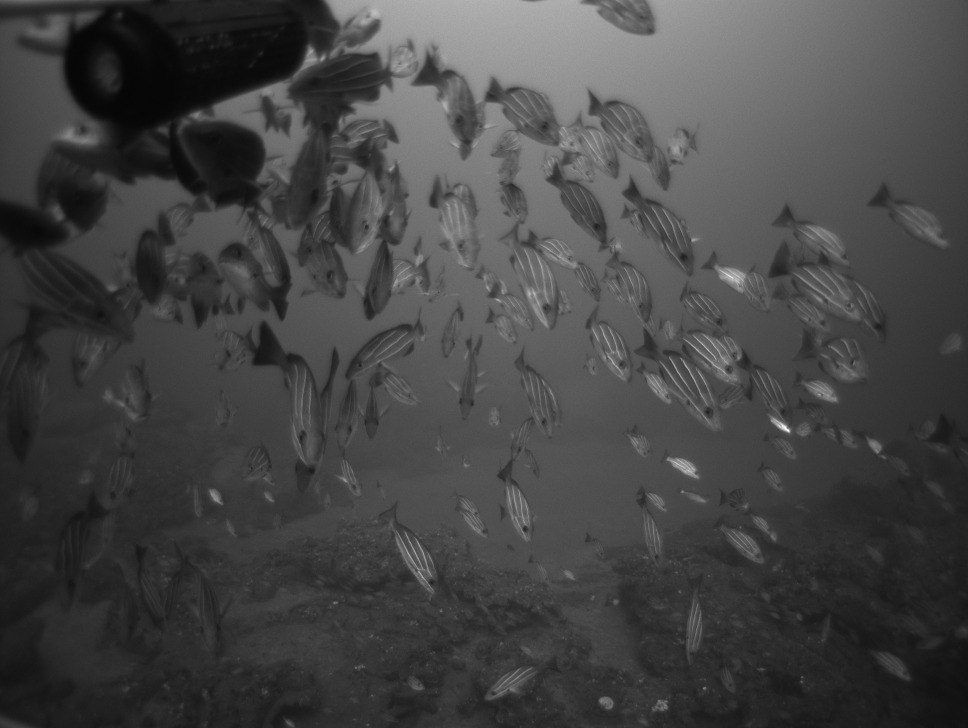

In [21]:
import torch
from PIL import Image

# Load and preprocess
image = Image.open(random_img).convert('RGB')
image

In [22]:
trained_model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(32

In [43]:
predicted_boxes, predicted_paths, predicted_path_scores = hierarchical_yolo.utils.hierarchical_predict(trained_model, Deep7HierarchicalDetectionTrainer._hierarchy, [image, image], cuda=True)

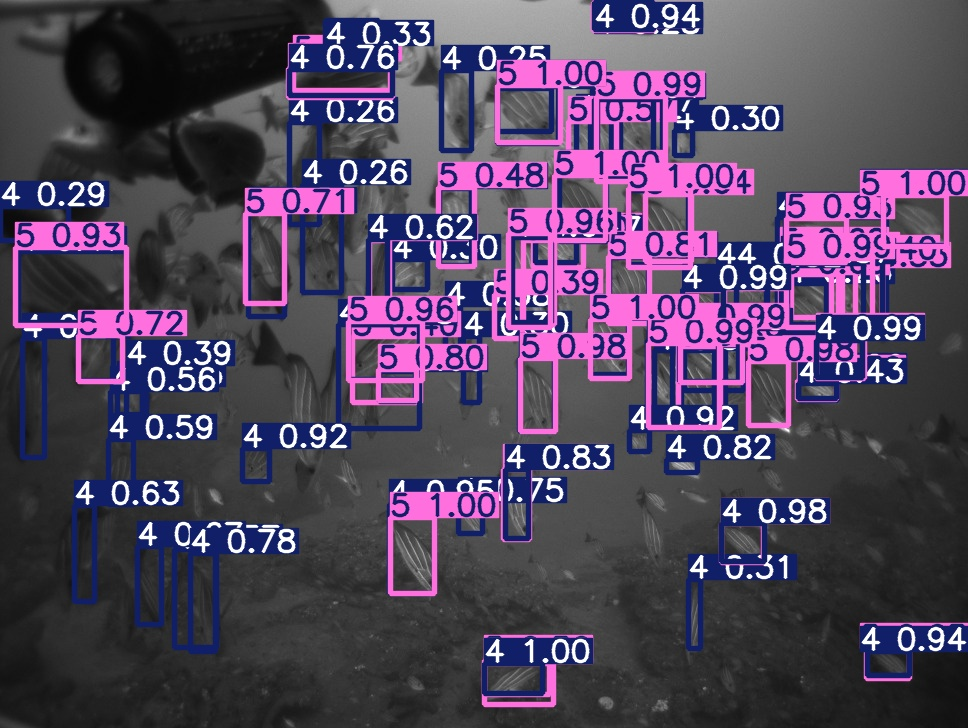

In [47]:
prediction.save('pickles.jpg')
from IPython.display import Image
Image(filename='pickles.jpg') 